In [3]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import dask.dataframe as dd

c:\Users\DIEGO\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Se modificó el dataset original

Se duplicó el número de ejemplos de 50.000 a 100.000 ejemplos. También se adicionaron 3 nuevas columnas que son:

- category_char (Columna 3074): Indica si la imagen pertenece a un "vehículo" (V), un "animal" (A), o un "objeto volador" (F).
- category_text (Columna 3075): Proporciona una descripción textual de la clase de cada imagen. Por ejemplo, "avión", "automóvil", etc.
- category_bool (Columna 3076): Indica si la imagen pertenece a un "vehículo" (True) o a un "animal" (False).

In [8]:
# Configuración
input_layer_size = 3072
num_labels = 10

# Cargar el dataset original
data = pd.read_csv('train.csv')

# Dividir las características y las etiquetas
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Mapeo de clases
class_names = {
    0: ('F', 'avión', True),
    1: ('V', 'automóvil', True),
    2: ('F', 'pájaro', False),
    3: ('A', 'gato', False),
    4: ('A', 'ciervo', False),
    5: ('A', 'perro', False),
    6: ('A', 'rana', False),
    7: ('A', 'caballo', False),
    8: ('V', 'barco', True),
    9: ('V', 'camión', True)
}

# Crear nuevas columnas en el DataFrame original
data['category_char'] = data['label'].map(lambda x: class_names[x][0])
data['category_text'] = data['label'].map(lambda x: class_names[x][1])
data['category_bool'] = data['label'].map(lambda x: class_names[x][2])

# Crear dataset sintético con ruido
num_samples = len(data)
noise = np.random.normal(0, 0.001, X.shape)
X_duplicated = X + noise

# Crear DataFrame para los datos sintéticos
data_sintetico = pd.DataFrame(X_duplicated, columns=[f'pixel_{i}' for i in range(input_layer_size)])
data_sintetico['label'] = y
data_sintetico['category_char'] = data['category_char']
data_sintetico['category_text'] = data['category_text']
data_sintetico['category_bool'] = data['category_bool']

# Concatenar los datos originales y sintéticos
df_sintetico = pd.concat([data, data_sintetico], ignore_index=True)
df_sintetico.to_csv('dataset_sintetico.csv', index=False)

print(f"El nuevo dataset sintético con {df_sintetico.shape[0]} ejemplos ha sido guardado en 'dataset_sintetico.csv'")

El nuevo dataset sintético con 100000 ejemplos ha sido guardado en 'dataset_sintetico.csv'


### Grafica representativa de los datos del dataset inicial y otra con los datos del dataset sintético generado

Histogramas de Distribución de Características

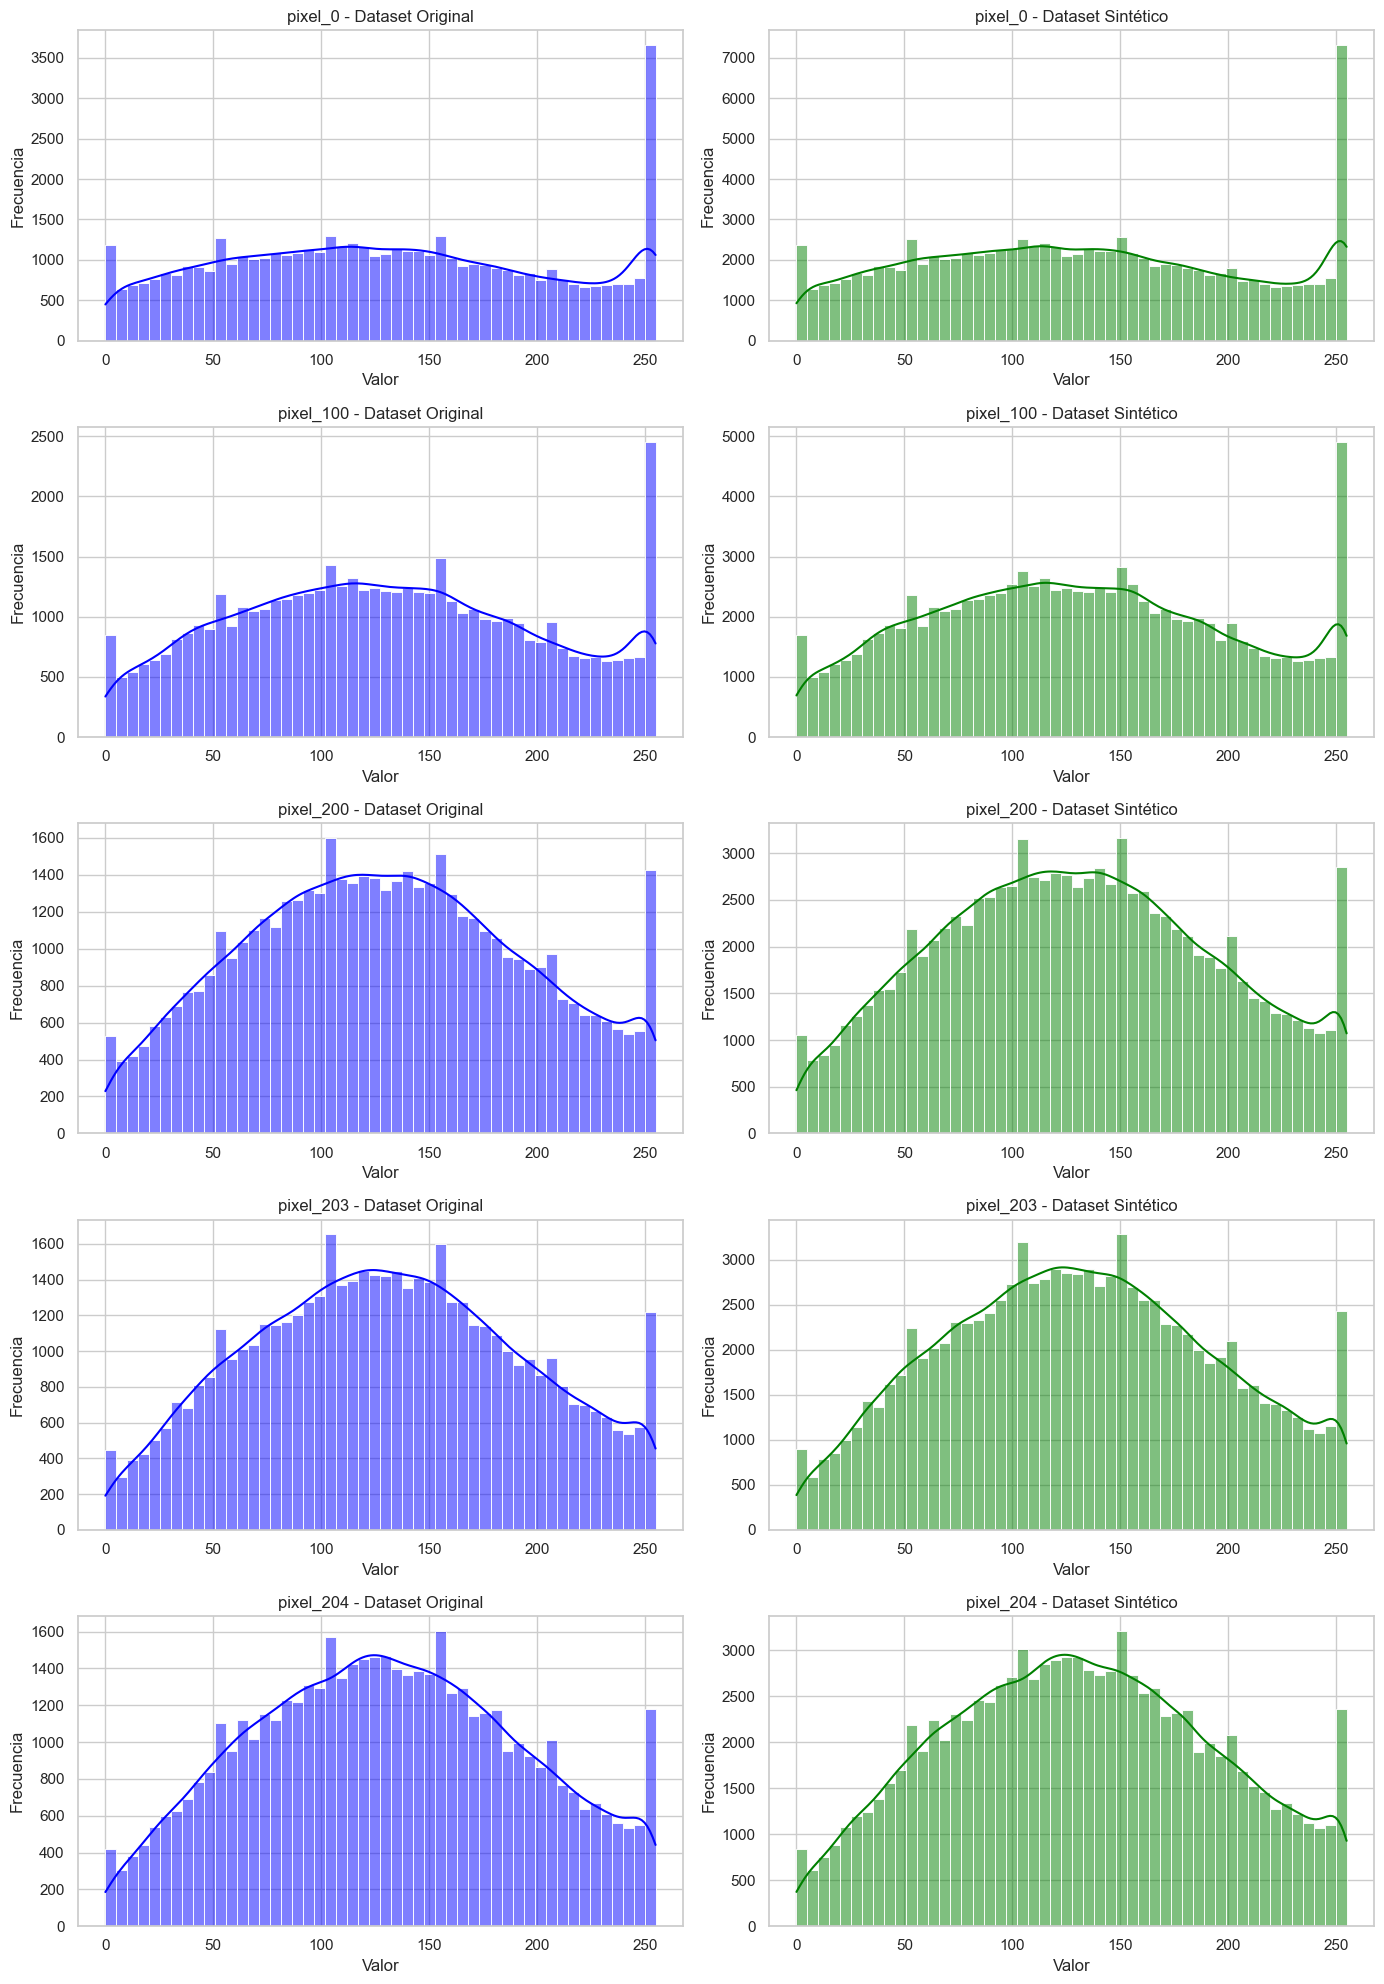

In [28]:
# Definir una muestra de características para visualizar
sample_features = ['pixel_0', 'pixel_100', 'pixel_200', 'pixel_203', 'pixel_204']  # Puedes ajustar esta lista según lo necesites

# Crear una figura con dos subgráficos por característica
fig, axes = pyplot.subplots(nrows=len(sample_features), ncols=2, figsize=(14, len(sample_features) * 4))

# Graficar histogramas para cada característica en el dataset original y sintético
for i, feature in enumerate(sample_features):
    # Histograma para el dataset original
    sns.histplot(data[feature], bins=50, kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'{feature} - Dataset Original')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frecuencia')
    
    # Histograma para el dataset sintético
    sns.histplot(data_sintetico[feature], bins=50, kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{feature} - Dataset Sintético')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frecuencia')

# Ajustar el espaciado entre los gráficos
pyplot.tight_layout()
pyplot.show()


Gráficos de Dispersión

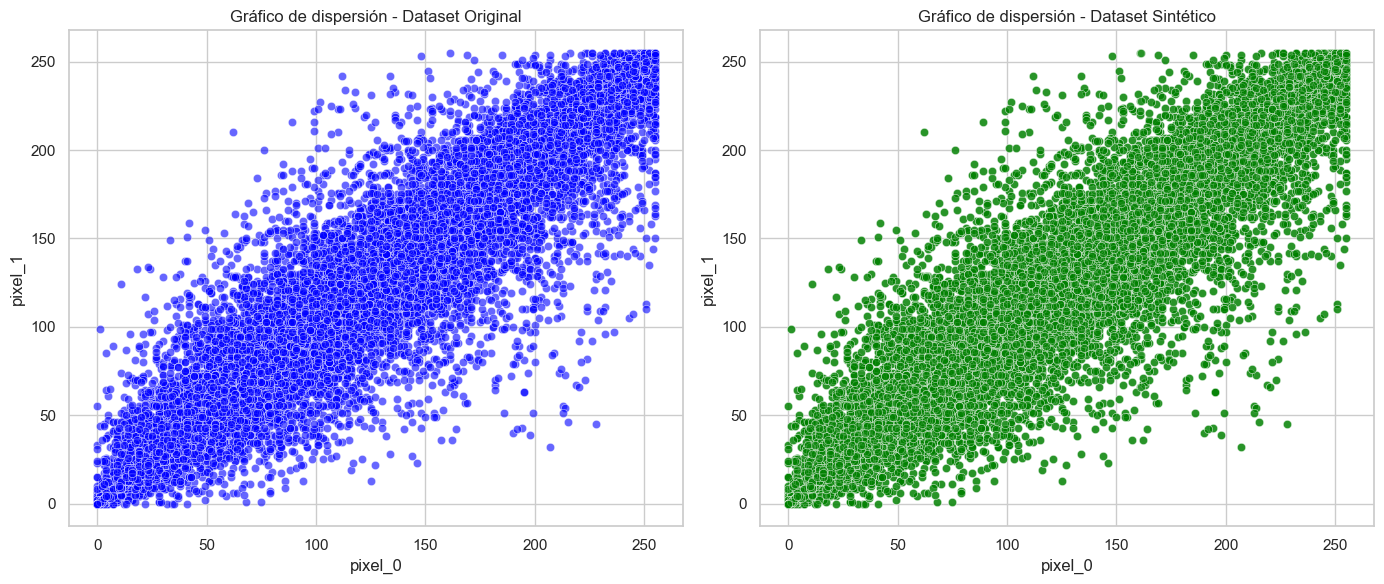

In [29]:
# Definir dos características para graficar
feature_x = 'pixel_0'
feature_y = 'pixel_1'

# Crear una figura con dos subgráficos
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico de dispersión para el dataset original
sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('Gráfico de dispersión - Dataset Original')
axes[0].set_xlabel(feature_x)
axes[0].set_ylabel(feature_y)

# Gráfico de dispersión para el dataset sintético
sns.scatterplot(x=data_sintetico[feature_x], y=data_sintetico[feature_y], ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Gráfico de dispersión - Dataset Sintético')
axes[1].set_xlabel(feature_x)
axes[1].set_ylabel(feature_y)

# Ajustar el espaciado entre los gráficos
pyplot.tight_layout()
pyplot.show()


### Dividir los datos del dataset sintético en datos de entrenamiento y prueba

In [27]:
# Leer el dataset usando Dask
df = dd.read_csv('dataset_sintetico.csv')

# Convertir el Dask DataFrame a Pandas DataFrame (esto será intensivo en memoria si el dataset es grande)
df_pandas = df.compute()

# Dividir en datos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test = train_test_split(
    df_pandas, test_size=0.2, random_state=42, stratify=df_pandas['label']
)

# Guardar los conjuntos de entrenamiento y prueba en archivos CSV
X_train.to_csv('sintetico_train.csv', index=False)
X_test.to_csv('sintetico_test.csv', index=False)

# Imprimir el tamaño de cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]} ejemplos, {X_train.shape[1]} columnas")
print(f"Conjunto de prueba: {X_test.shape[0]} ejemplos, {X_test.shape[1]} columnas")

Conjunto de entrenamiento: 80000 ejemplos, 3076 columnas
Conjunto de prueba: 20000 ejemplos, 3076 columnas


### modelo de regresión logística por separado, considerando el numero de clases que se vinculan al dataset elegido.

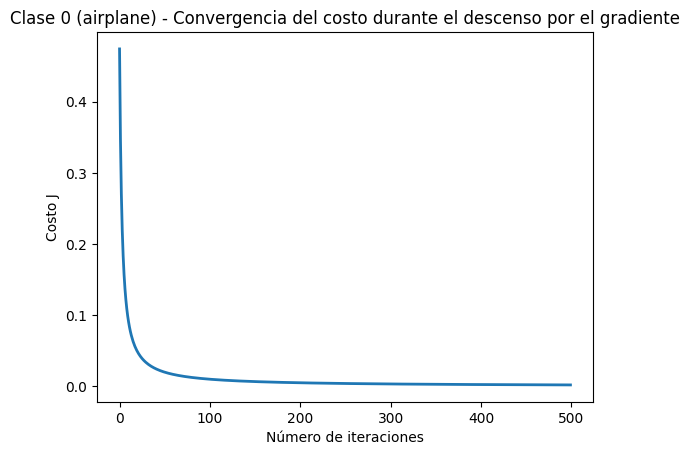

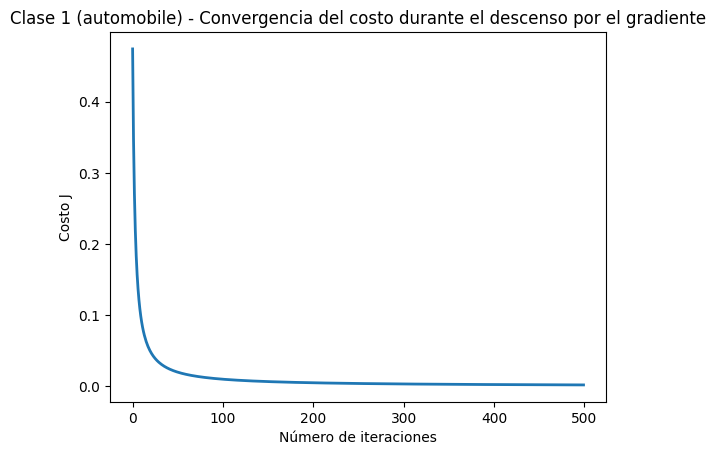

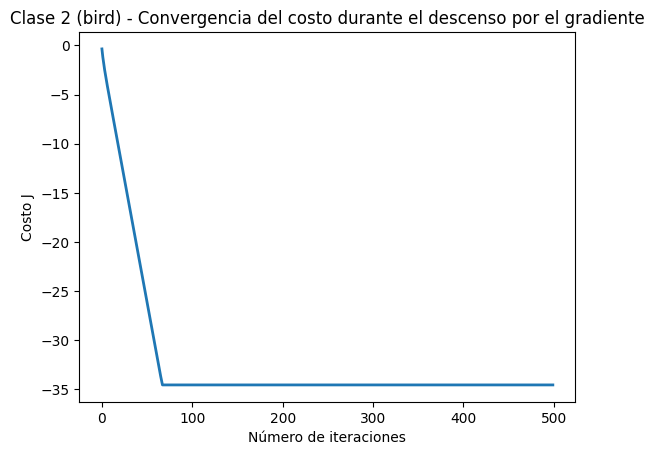

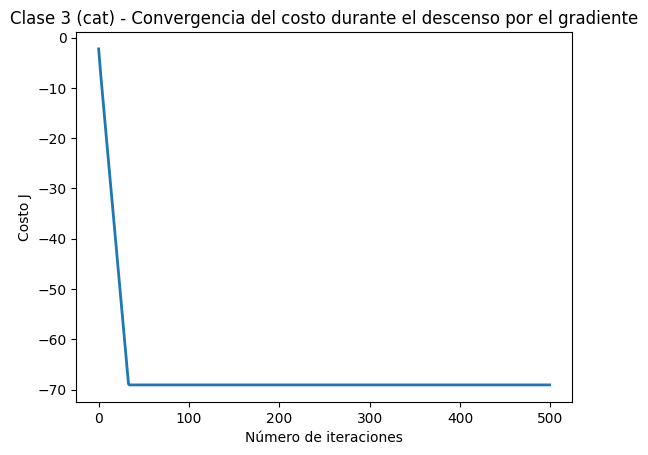

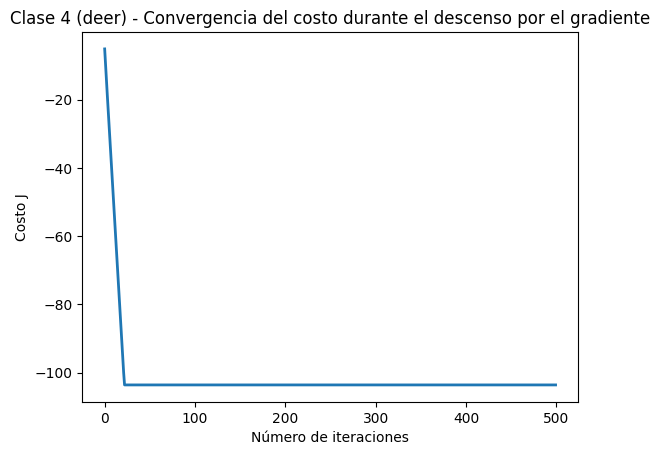

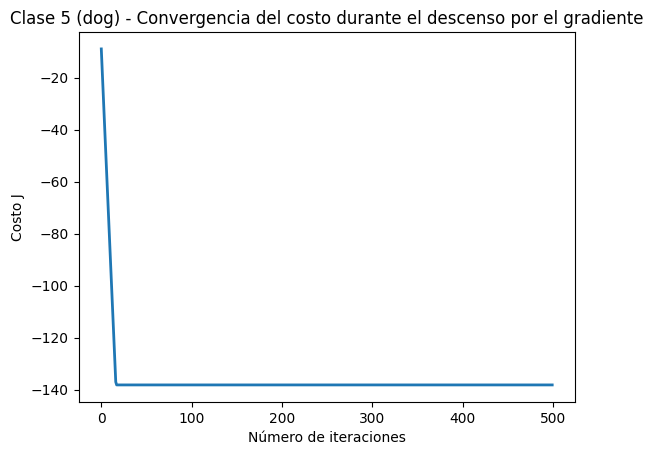

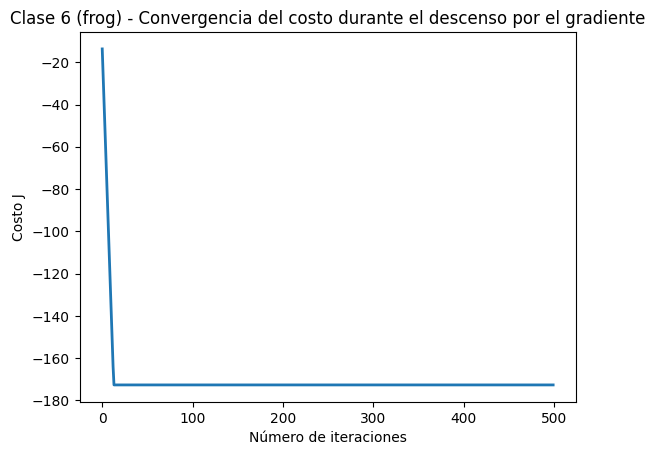

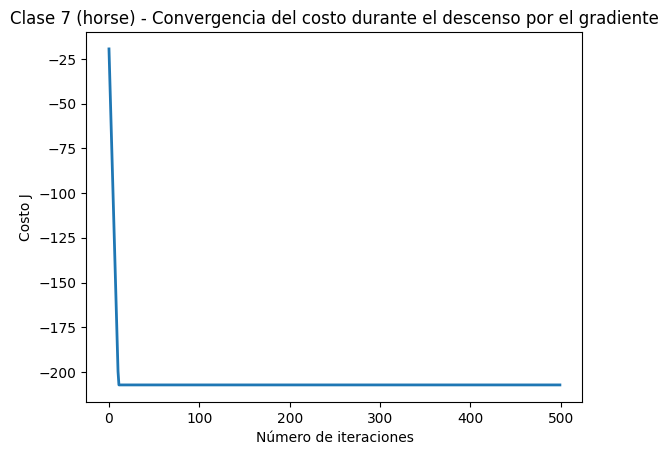

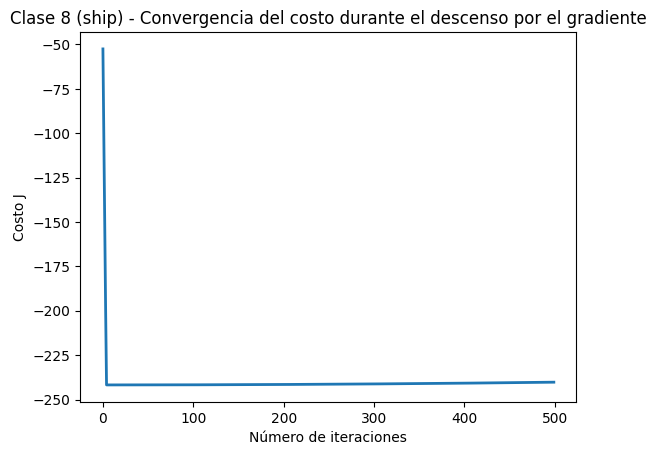

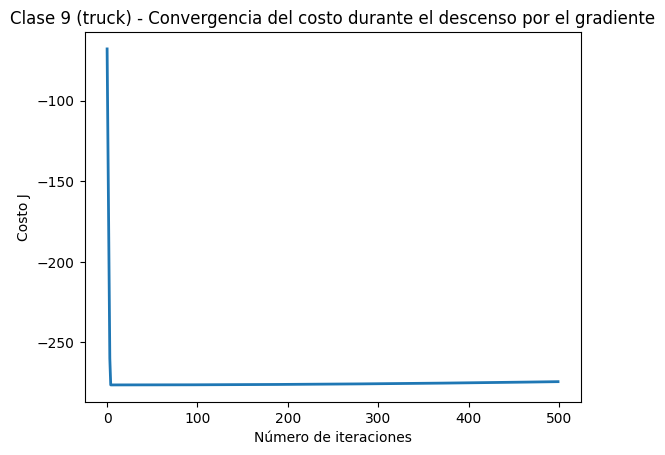

In [38]:
# Leer el dataset en chunks
chunk_size = 10000
chunks = pd.read_csv('sintetico_train.csv', chunksize=chunk_size)

# Etiquetas para las clases
class_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Función sigmoide
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Función de costo con regularización
def calcularCosto(theta, X, y, lambda_):
    m = y.size  # Número de ejemplos
    # Si las etiquetas son booleanas, conviértelas a enteros
    if y.dtype == bool:
        y = y.astype(int)
    # Calculamos la hipótesis
    h = sigmoid(X.dot(theta.T))
    # Aseguramos que los valores de h estén en un rango adecuado para evitar log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    # Calculamos el término de regularización (exceptuando theta[0])
    temp = theta.copy()
    temp[0] = 0  # No regularizamos el término de sesgo (theta[0])
    # Función de costo con regularización
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) \
        + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    # Gradiente con regularización (no regularizamos theta[0])
    grad = (1 / m) * (X.T.dot(h - y)) + (lambda_ / m) * temp
    return J, grad

# Descenso por el gradiente
def descensoGradiente(theta, X, y, alpha, num_iters, lambda_):
    m = y.shape[0]
    J_history = []
    for i in range(num_iters):
        h = sigmoid(X.dot(theta))
        gradient = (1 / m) * X.T.dot(h - y) + (lambda_ / m) * np.concatenate([[0], theta[1:]])
        theta -= alpha * gradient
        J, _ = calcularCosto(theta, X, y, lambda_)
        J_history.append(J)
    return theta, J_history

# Inicializa parámetros para el descenso por el gradiente
alpha = 0.5
num_iters = 500
lambda_ = 0.001

# Graficar la función de costo para cada clase
for label, class_name in class_labels.items():
    # Procesar cada chunk
    for chunk in chunks:
        # Convertir los valores booleanos de 'category_bool' a numéricos
        X = chunk['category_bool'].astype(int).values.reshape(-1, 1)  # Convertir True/False a 1/0

        # Filtrar para obtener solo las filas donde 'label' es igual al valor actual
        mask = chunk['label'] == label
        if np.sum(mask) == 0:
            print(f"No hay instancias con la clase {label} ({class_name}) en este chunk.")
            continue

        X = X[mask]
        y = chunk['label'][mask].values

        # Añadir una columna de unos para el término de sesgo
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Inicializa theta para el descenso por el gradiente
        initial_theta = np.zeros(X.shape[1])

        # Ejecuta el descenso por el gradiente
        theta, J_history = descensoGradiente(initial_theta, X, y, alpha, num_iters, lambda_)

        # Graficar la convergencia del costo
        pyplot.figure()
        pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
        pyplot.xlabel('Número de iteraciones')
        pyplot.ylabel('Costo J')
        pyplot.title(f'Clase {label} ({class_name}) - Convergencia del costo durante el descenso por el gradiente')
        pyplot.show()

        # Salir del loop de chunks después de procesar la clase
        break

    # Asegúrate de que los chunks se reinicien para la próxima clase
    chunks = pd.read_csv('sintetico_train.csv', chunksize=chunk_size)


### Entrenamiento con modelo One-vs-All

In [41]:
# Ingresar imágenes de dígitos de 20x20
input_layer_size  = 3072

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 10

# Leer el archivo CSV usando pandas
df = pd.read_csv('sintetico_train.csv')

# Seleccionar columnas de píxeles (0-3071)
X_pixels = df.iloc[:, :3072].values  # Primeros 3072 datos son los píxeles

# Convertir la columna 'label' en etiquetas (solo para la variable y)
y = df['label'].values

# Convertir 'category_char', 'category_text', y 'category_bool' a valores numéricos
# Crear un mapa de los valores a números
category_char_map = {'F': 0, 'V': 1, 'A': 2}
category_text_map = {'avión': 0, 'automóvil': 1, 'pájaro': 2, 'gato': 3, 'ciervo': 4, 'perro': 5, 'rana': 6, 'caballo': 7, 'barco': 8, 'camión': 9}
category_bool_map = {True: 1, False: 0}

# Convertir las columnas usando los mapas
category_char_numeric = df['category_char'].map(category_char_map).values
category_text_numeric = df['category_text'].map(category_text_map).values
category_bool_numeric = df['category_bool'].map(category_bool_map).values

# Crear una matriz con las características adicionales
X_additional = np.vstack((category_char_numeric, category_text_numeric, category_bool_numeric)).T

# Concatenar las características de píxeles y características adicionales
X = np.hstack((X_pixels, X_additional))

m = y.size

# Verificar la forma de los datos
print(f'Forma de X: {X.shape}')
print(f'Forma de y: {y.shape}')

Forma de X: (80000, 3075)
Forma de y: (80000,)


In [42]:
def displayData(X_pixels, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X_pixels.ndim == 2:
        m, n = X_pixels.shape
    elif X_pixels.ndim == 1:
        n = X_pixels.size
        m = 1
        X_pixels = X_pixels[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    # Ancho de cada imagen
    example_width = example_width or int(np.round(np.sqrt(n // 3)))
    example_height = int(n / (example_width * 3))  # Para imágenes RGB (3 canales)

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Redimensionar cada imagen para mostrarla en formato 32x32 píxeles con 3 canales de color
        img = X_pixels[i].reshape(example_height, example_width, 3, order='F')
        ax.imshow(img.astype(np.uint8), extent=[0, 1, 0, 1])
        ax.axis('off')

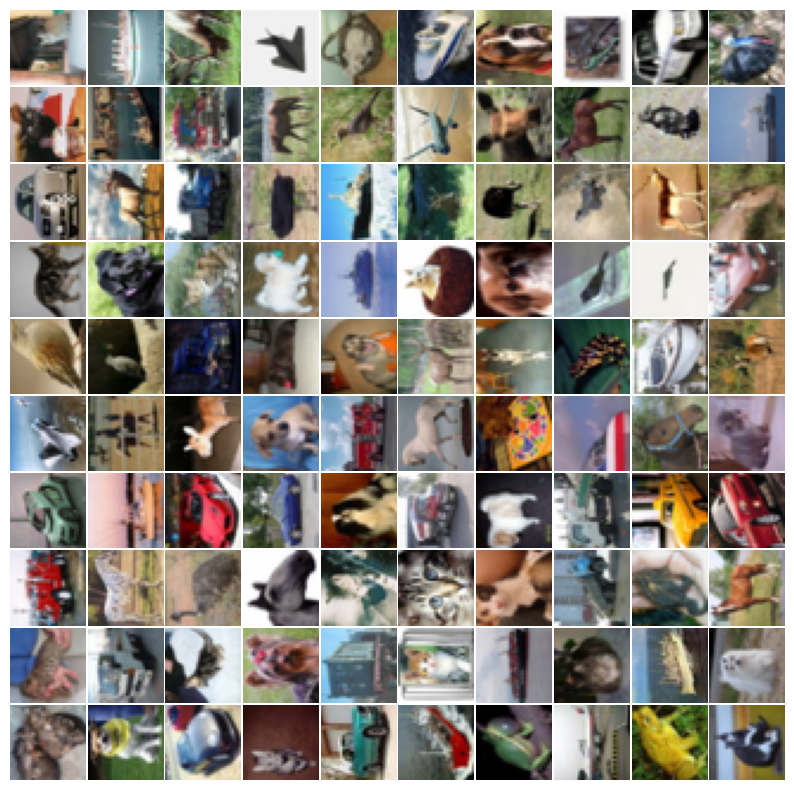

In [43]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X_pixels[rand_indices, :]

displayData(sel)

In [44]:
# Normalizar las características
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X, mu, sigma = featureNormalize(X)

In [45]:
# Añadir una columna de unos para el término de sesgo
X = np.hstack([np.ones((X.shape[0], 1)), X])

### 1.3 Vectorización de regresión logística

Se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 10 clases, deberá entrenar 10 clasificadores de regresión logística separados. Para que esta capacitación sea eficiente, es importante asegurarse de que el código esté bien vectorizado.

En esta sección, se implementará una versión vectorizada de regresión logística que no emplea ningún bucle "for".

Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

<a id="section1"></a>
#### 1.3.1 Vectorización de la funcion de costo

Se inicia escribiendo una versión vectorizada de la función de costo. En la regresión logística (no regularizada), la función de costo es

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

Para calcular cada elemento en la suma, tenemos que calcular $h_\theta(x^{(i)})$ para cada ejemplo $i$, donde $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ y $g(z) = \frac{1}{1+e^{-z}}$ es la funcion sigmoidea. Resulta que podemos calcular esto rápidamente para todos los ejemplos usando la multiplicación de matrices. Definamos $X$ y $\theta$ como

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Luego, de calcular el producto matricial $X\theta$, se tiene:

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

En la última igualdad, usamos el hecho de que $a^Tb = b^Ta$ if $a$ y $b$ son vectores. Esto permite calcular los productos $\theta^T x^{(i)}$ para todos los ejemplos $i$ en una linea de codigo.

#### 1.3.2 Vectorización del gradiente

Recordemos que el gradiente del costo de regresión logística (no regularizado) es un vector donde el elemento $j^{th}$ se define como
$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

Para vectorizar esta operación sobre el conjunto de datos, se inicia escribiendo todas las derivadas parciales explícitamente para todos $\theta_j$,

$$
\begin{align*}
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

donde

$$  h_\theta(x) - y =
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)}
\end{bmatrix} $$

Nota $x^{(i)}$ es un vector, mientras $h_\theta\left(x^{(i)}\right) - y^{(i)}$ es un escalar(simple número).
Para comprender el último paso de la derivación, dejemos $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ y
observar que:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

donde los valores $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

La expresión anterior nos permite calcular todas las derivadas parciales sin bucles.
Si se siente cómodo con el álgebra lineal, le recomendamos que trabaje con las multiplicaciones de matrices anteriores para convencerse de que la versión vectorizada hace los mismos cálculos.

<div class="alert alert-box alert-warning">
** Consejo de depuración: ** El código de vectorización a veces puede ser complicado. Una estrategia común para la depuración es imprimir los tamaños de las matrices con las que está trabajando usando la propiedad `shape` de las matrices` numpy`.

Por ejemplo, dada una matriz de datos $X$ de tamaño $100\veces 20$ (100 ejemplos, 20 características) y $\theta$, un vector con tamaño $20$, puede observar que `np.dot (X, theta) `es una operación de multiplicación válida, mientras que` np.dot (theta, X) `no lo es.

Además, si tiene una versión no vectorizada de su código, puede comparar la salida de su código vectorizado y el código no vectorizado para asegurarse de que produzcan las mismas salidas.</div>
<a id="lrCostFunction"></a>

In [46]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [47]:
def lrCostFunction(theta, X, y, lambda_):
    m = y.size
    h = sigmoid(X.dot(theta))
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    
    temp = theta.copy()
    temp[0] = 0  # No regularizamos el término de sesgo (theta[0])
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) \
        + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (X.T.dot(h - y)) + (lambda_ / m) * temp
    
    return J, grad

In [59]:
def gradientDescent(X, y, theta, alpha, num_iters, lambda_):
    m = y.size  # Número de ejemplos
    J_history = []  # Lista para almacenar los costos en cada iteración
    
    for i in range(num_iters):
        # Calculamos el costo y el gradiente
        J, grad = lrCostFunction(theta, X, y, lambda_)
        
        # Guardamos el costo en J_history
        J_history.append(J)
        
        # Actualizamos los parámetros usando el gradiente descendente
        theta = theta - alpha * grad
    
    return theta, J_history


In [60]:
def oneVsAll(X, y, num_labels, lambda_, alpha, num_iters):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))  # Inicializamos theta para cada clase
    J_histories = []  # Lista para almacenar los costos de cada clase
    
    for c in range(num_labels):
        initial_theta = np.zeros(n)
        theta, J_history = gradientDescent(X, (y == c).astype(int), initial_theta, alpha, num_iters, lambda_)
        all_theta[c] = theta
        J_histories.append(J_history)  # Guardamos el historial de costos de esta clase
    
    return all_theta, J_histories


In [90]:
# Parámetros de entrenamiento
lambda_ = 1
alpha = 0.01
num_iters = 300
num_labels = 10

# Entrenamiento del clasificador One-vs-All usando gradiente descendente
all_theta, J_histories = oneVsAll(X, y, num_labels, lambda_, alpha, num_iters)

# Predicciones
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    p = np.zeros(m)
    
    predictions = sigmoid(X.dot(all_theta.T))
    p = np.argmax(predictions, axis=1)
    
    return p


calculando precisión y mostrando la función de costo

Precisión del conjunto de entrenamiento: 66.73%


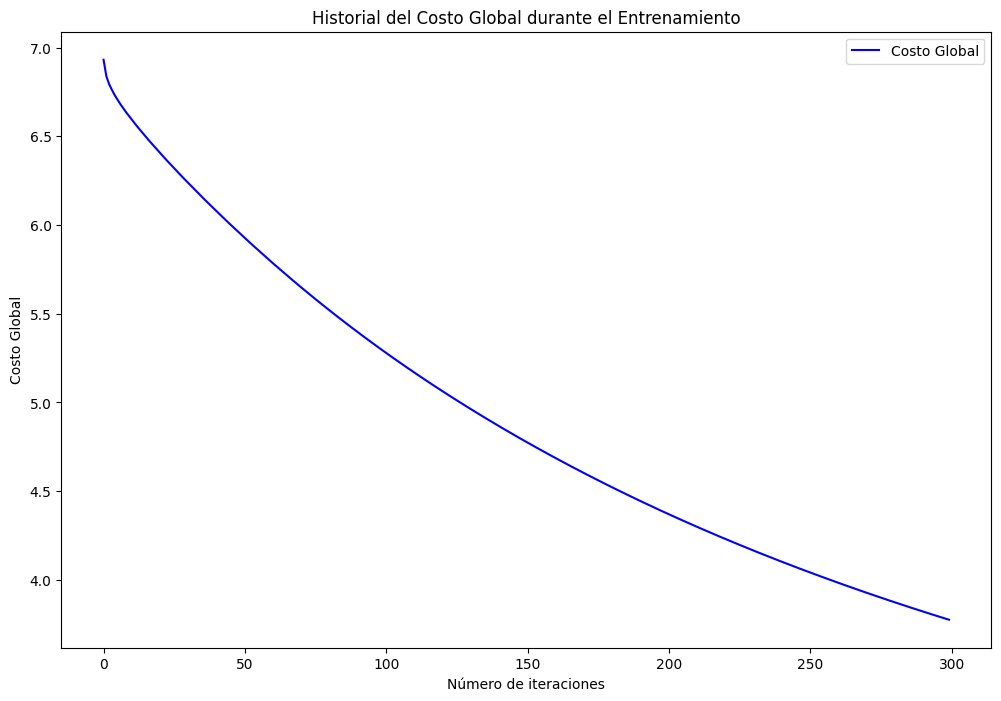

In [91]:
# Calcular la precisión
pred = predictOneVsAll(all_theta, X)
print('Precisión del conjunto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))

# Calcular el costo global sumando o promediando los costos de todas las clases
J_global = np.sum(J_histories, axis=0)

# Graficar el costo global
pyplot.figure(figsize=(12, 8))
pyplot.plot(J_global, label='Costo Global', color='b')

pyplot.xlabel('Número de iteraciones')
pyplot.ylabel('Costo Global')
pyplot.title('Historial del Costo Global durante el Entrenamiento')
pyplot.legend()
pyplot.show()

### Verificar efectividad con dataset de prueba

In [92]:
# Cargar el dataset de prueba
df_test = pd.read_csv('sintetico_test.csv')

# Seleccionar las columnas de píxeles y las características adicionales como en el conjunto de entrenamiento
X_test_pixels = df_test.iloc[:, :3072].values  # Primeros 3072 valores son píxeles

# Convertir las columnas adicionales de 'category_char', 'category_text', y 'category_bool' a valores numéricos
category_char_numeric_test = df_test['category_char'].map(category_char_map).values
category_text_numeric_test = df_test['category_text'].map(category_text_map).values
category_bool_numeric_test = df_test['category_bool'].map(category_bool_map).values

# Crear una matriz con las características adicionales
X_test_additional = np.vstack((category_char_numeric_test, category_text_numeric_test, category_bool_numeric_test)).T

# Concatenar las características de píxeles y las adicionales
X_test = np.hstack((X_test_pixels, X_test_additional))

# Agregar el término de sesgo (columna de unos) a X_test
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

In [99]:
# Cargar las etiquetas del conjunto de prueba
y_test = df_test['label'].values

# Hacer predicciones en el conjunto de prueba
pred_test = predictOneVsAll(all_theta, X_test)

# Calcular la precisión en el conjunto de prueba
precision_test = np.mean(pred_test == y_test) * 100

# Imprimir la precisión
print(f'Precisión en el conjunto de prueba: {precision_test:.2f}%')

# Seleccionar aleatoriamente algunos ejemplos del conjunto de prueba para visualización
rand_indices_test = np.random.choice(X_test.shape[0], 10, replace=False)
X_test_sample = X_test[rand_indices_test, :]
y_test_sample = y_test[rand_indices_test]
pred_test_sample = pred_test[rand_indices_test]

# Mostrar predicciones y etiquetas reales
print('Predicciones:', pred_test_sample)
print('Etiquetas Reales:', y_test_sample)

Precisión en el conjunto de prueba: 22.61%
Predicciones: [0 0 0 0 1 8 8 1 4 0]
Etiquetas Reales: [3 5 4 4 1 4 6 1 4 8]
